In [1]:
import pandas as pd


file_list = [
    
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_1_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_2_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_3_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_4_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_5_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_6_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_7_7.csv'
]

# 从CSV文件读取数据，并将日期列转换为datetime类型
df_list = [pd.read_csv(f, parse_dates=["IncorporationDate"]) for f in file_list]

# 合并所有数据框为一个大的数据框
df = pd.concat(df_list, ignore_index=True)
df.dropna(subset=['lat', 'long'], inplace=True)

# Save the processed dataframe to a new CSV file
#output_file_path = "/Users/rainfow/Desktop/Summer projects/companies_data/used_companies_data.csv"
#df.to_csv(output_file_path, index=False)


In [2]:
def filter_by_postcode_prefix(df, prefix):
    # Split the postcode at the space to get the prefix
    df['PostCodePrefix'] = df['RegAddress.PostCode'].str.split().str[0]
    # Filter the DataFrame based on the prefix
    df_filtered = df[df['PostCodePrefix'].str.startswith(prefix)]
    return df_filtered

df_filtered = filter_by_postcode_prefix(df, 'WC2')
df_filtered.head()

,CompanyName,RegAddress.PostCode,lat,long,CompanyCategory,IncorporationDate,SICCode.SicText_1,PostCodePrefix
5,!NFOGENIE LTD,WC2H 9JQ,51.514897,-0.123615,Private Limited Company,2021-07-21,58290 - Other software publishing,WC2H
213,& PLAY LTD,WC2H 9JQ,51.514897,-0.123615,Private Limited Company,2023-03-30,62012 - Business and domestic software develop...,WC2H
274,&LLOYD LTD,WC2H 9JQ,51.514897,-0.123615,Private Limited Company,2023-01-26,70229 - Management consultancy activities othe...,WC2H
281,&OFFICES CANARY WHARF LIMITED,WC2N 6JU,51.508769,-0.122941,Private Limited Company,2011-12-14,68320 - Management of real estate on a fee or ...,WC2N
283,&OFFICES VICTORIA LIMITED,WC2N 6JU,51.508769,-0.122941,Private Limited Company,2004-03-23,68209 - Other letting and operating of own or ...,WC2N


In [3]:
import numpy as np

#df_filtered['Date'] = df_filtered['IncorporationDate'].dt.to_period('D')
df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


##df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().reset_index(name='CompanyCount')
##print(df_filtered_count.head(50))

df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).agg({
    'CompanyName': lambda x: list(x),
    'lat': 'first',
    'long': 'first',
    'SICCode.SicText_1': lambda x: list(x),
}).reset_index()

# df_filtered_count['CompanyCount'] = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().values

df_filtered_count.head()


/var/folders/00/r2pslk7j4k158048921m90wm0000gn/T/ipykernel_86113/2322913796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1
0,WC2A 1AA,1994-07-15,[CITY OPTICIANS LIMITED],51.517941,-0.113959,[47789 - Other retail sale of new goods in spe...
1,WC2A 1AA,2023-03-06,[J&T GOODS LTD],51.517941,-0.113959,[46160 - Agents involved in the sale of textil...
2,WC2A 1AD,2021-11-17,[CYNAPPZ LTD],51.518087,-0.113928,[62020 - Information technology consultancy ac...
3,WC2A 1AD,2022-02-16,[LOVE TEAM LTD],51.518087,-0.113928,[62020 - Information technology consultancy ac...
4,WC2A 1AF,1960-04-13,[PB LTD],51.517907,-0.113471,[70100 - Activities of head offices]


In [4]:
def calculate_density_scores(df):
    
    # Create a window column based on the date for half-year grouping
    df['Date'] = pd.to_datetime(df['Date'])
    df['Window'] = df['Date'].apply(lambda x: f"{x.year}-H1" if x.month <= 6 else f"{x.year}-H2")

    # Group by the window and postcode to get the number of companies for each postcode in each window
    df_grouped = df.groupby(['Window', 'RegAddress.PostCode']).size().reset_index(name='CompaniesCount')

    # Calculate the average number of companies for each window and merge it with the grouped dataframe
    avg_counts = df_grouped.groupby('Window')['CompaniesCount'].mean().reset_index()
    avg_counts.columns = ['Window', 'CompaniesCount_avg']
    df_grouped = df_grouped.merge(avg_counts, on='Window', how='left')

    # Calculate the difference from the average for each postcode in each window
    df_grouped['CompaniesCount_avg'] = np.ceil(df_grouped['CompaniesCount_avg'])
    df_grouped['Difference_from_Avg'] = df_grouped['CompaniesCount'] - df_grouped['CompaniesCount_avg']
    
    # Identify the postcodes with anomalous company counts for each window
    anomalies = df_grouped[df_grouped['Difference_from_Avg'] > df_grouped['CompaniesCount_avg']]

    # Calculate the cumulative scores for each postcode
    cumulative_scores = anomalies.groupby('RegAddress.PostCode').size() * 0.5
    cumulative_scores_df = cumulative_scores.reset_index()
    cumulative_scores_df.columns = ['RegAddress.PostCode', 'density_score']

    # Merge the cumulative scores with the original dataset
    df_final = df.merge(cumulative_scores_df, on='RegAddress.PostCode', how='left')

    # Fill NaN scores with 0
    df_final['density_score'] = df_final['density_score'].fillna(0)
    
    return df_final


In [5]:
# Re-define the modified function
def calculate_frequency_scores(df, n=2):

    # Sort dataframe by postcode and date
    df = df.sort_values(by=['RegAddress.PostCode', 'Date'])
    
    # Calculate the difference in days between two consecutive rows for each postcode
    df['Time_Diff'] = df.groupby('RegAddress.PostCode')['Date'].diff().dt.days

    # Get the minimum time difference for each postcode
    min_time_diffs = df.groupby('RegAddress.PostCode')['Time_Diff'].min().reset_index()
    
    # Handle postcodes with only one company (hence NaN in Time_Diff)
    single_company_postcodes = min_time_diffs[min_time_diffs['Time_Diff'].isna()]['RegAddress.PostCode'].tolist()
    df.loc[df['RegAddress.PostCode'].isin(single_company_postcodes), 'Time_Diff'] = np.inf
    min_time_diffs.loc[min_time_diffs['RegAddress.PostCode'].isin(single_company_postcodes), 'Time_Diff'] = np.inf
    
    # Sort by minimum time difference and assign ranks
    min_time_diffs = min_time_diffs.sort_values(by='Time_Diff')
    min_time_diffs['Rank'] = range(1, len(min_time_diffs) + 1)
    
    # Calculate the maximum rank for the exponential scoring function
    max_rank = len(min_time_diffs)
    
    # Define the exponential scoring function
    def exponential_score(rank, max_rank, n=2):
        return 5 * ((max_rank - rank + 1) / max_rank) ** n
    
    # Apply the exponential score formula
    min_time_diffs['frequency_Score'] = min_time_diffs['Rank'].apply(lambda x: round(exponential_score(x, max_rank, n=n), 1))
    
    # Assign a fixed frequency_Score for postcodes with only one company
    min_time_diffs.loc[min_time_diffs['Time_Diff'] == np.inf, 'frequency_Score'] = 0.0  # Assigning a fixed value
    
    # Merge the scores back to the original dataframe
    df = df.merge(min_time_diffs[['RegAddress.PostCode', 'frequency_Score']], on='RegAddress.PostCode', how='left')
    df = df.drop(columns=['Time_Diff'])  # Drop the Time_Diff column
    
    return df



In [6]:
# Combine both scoring methods and then aggregate for the final result
def compute_combined_scores(df):
    # Get the scores from both methods
    df_cumulative_scores = calculate_density_scores(df)
    df_postcode_scores = calculate_frequency_scores(df)
    
    # Combine both scores
    df['density_score'] = df_cumulative_scores['density_score']
    df['frequency_Score'] = df_postcode_scores['frequency_Score']
    
    # Calculate the total score
    df['Total_Score'] = df['density_score'] + df['frequency_Score']
    
    return df

# Compute the combined scores
df_dynamic_scores = compute_combined_scores(df_filtered_count)


In [7]:
# Group by postcode to get the total score for each postcode
dynamic_scores_output = df_dynamic_scores.groupby(['RegAddress.PostCode', 'lat', 'long']).agg({
    'CompanyName': 'size',
    'Total_Score': 'first'
}).reset_index()

dynamic_scores_output.rename(columns={'CompanyName': 'CompanyCount'}, inplace=True)
dynamic_scores_output.head(10)


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score
0,WC2A 1AA,51.517941,-0.113959,2,0.4
1,WC2A 1AD,51.518087,-0.113928,2,1.8
2,WC2A 1AF,51.517907,-0.113471,28,3.2
3,WC2A 1AH,51.517642,-0.112127,2,0.7
4,WC2A 1AL,51.517348,-0.111721,102,3.8
5,WC2A 1AN,51.517642,-0.112127,82,4.3
6,WC2A 1AP,51.517840,-0.112666,22,3.0
7,WC2A 1AR,51.517115,-0.111241,2,0.4
8,WC2A 1DD,51.515873,-0.112243,17,2.7
9,WC2A 1DT,51.515365,-0.111990,27,2.5


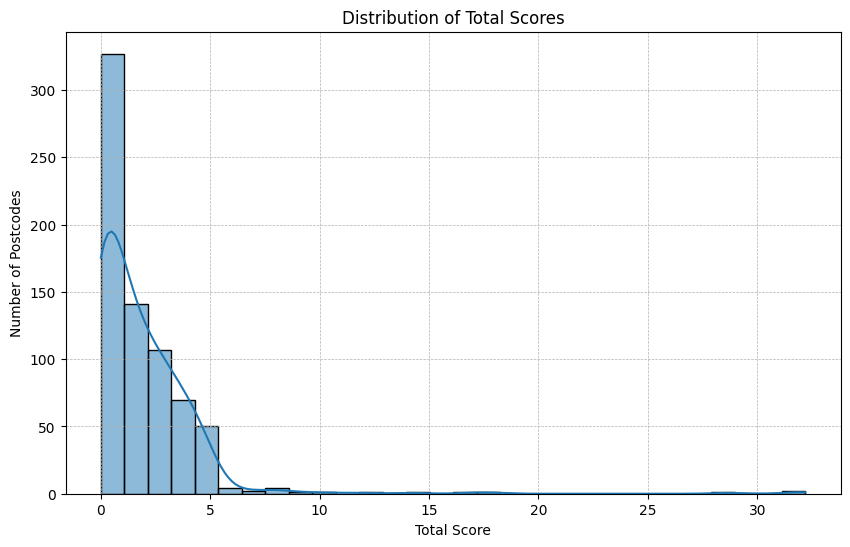

count    714.000000
mean       1.862465
std        2.719983
min        0.000000
25%        0.000000
50%        1.250000
75%        2.800000
max       32.200000
Name: Total_Score, dtype: float64

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical description of Total_Score
score_description = dynamic_scores_output["Total_Score"].describe()

# Plot the histogram for Total_Score
plt.figure(figsize=(10,6))
sns.histplot(dynamic_scores_output["Total_Score"], kde=True, bins=30)
plt.title("Distribution of Total Scores")
plt.xlabel("Total Score")
plt.ylabel("Number of Postcodes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

score_description


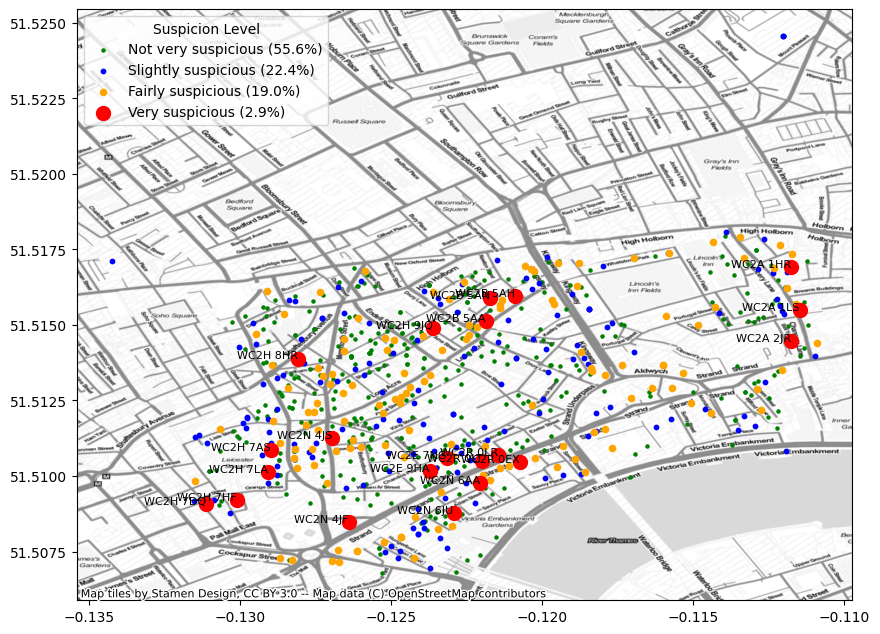

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define the color and size mapping based on the quantiles of 'SumScores'
def map_color_size(score):
    threshold_1 = 1.5
    threshold_2 = 3
    threshold_3 = 5

    if score <= threshold_1:
        return 'green', 5, 'Not very suspicious'
    elif score <= threshold_2:
        return 'blue', 10, 'Slightly suspicious'
    elif score <= threshold_3:
        return 'orange', 20, 'Fairly suspicious'
    else:
        return 'red', 100, 'Very suspicious'

dynamic_scores_output['color'], dynamic_scores_output['size'], dynamic_scores_output['label'] = zip(*dynamic_scores_output['Total_Score'].apply(map_color_size))

# Calculate the total number of postcodes
total_postcodes = len(dynamic_scores_output)

# Define a dictionary for labels, colors, and sizes
label_dict = {
    'Not very suspicious': {'color': 'green', 'size': 5},
    'Slightly suspicious': {'color': 'blue', 'size': 10},
    'Fairly suspicious': {'color': 'orange', 'size': 20},
    'Very suspicious': {'color': 'red', 'size': 100}
}

# Scatter plot
for label, attr in label_dict.items():
    idx = dynamic_scores_output['label'] == label
    postcode_count = len(dynamic_scores_output.loc[idx])
    percentage = postcode_count / total_postcodes * 100
    ax.scatter(dynamic_scores_output.loc[idx, 'long'], dynamic_scores_output.loc[idx, 'lat'], c=attr['color'], s=attr['size'], label=f'{label} ({percentage:.1f}%)')


    # If the label is "Very suspicious" (which corresponds to red), add the postal code text
    if label == "Very suspicious":
        for x, y, postcode in zip(dynamic_scores_output.loc[idx, 'long'], dynamic_scores_output.loc[idx, 'lat'], dynamic_scores_output.loc[idx, 'RegAddress.PostCode']):
            ax.text(x, y, postcode, ha='right', fontsize=8, color='black')

# Add legend
ax.legend(title="Suspicion Level")

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()
